<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#EnvFit" data-toc-modified-id="EnvFit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EnvFit</a></span><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Run</a></span></li><li><span><a href="#PCoA" data-toc-modified-id="PCoA-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>PCoA</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* EnvFit analysis with alpha diversity

# Var

In [17]:
# working dir
work_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/'

# bracken counts
brk_file = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/bracken_filt.qs'

# metadata
## filtered
#metadata_filt_file = file.path(work_dir, 'CurMetDat_metadata_filt-n1846.tsv')
## all 
base_in_dir = '/ebio/abt3_projects/small_projects/nyoungblut/public_data_retireval/'
metadata_file = file.path(base_in_dir, 'CurMetDat-metagenomes', 'files', 'metadata', 'Filtered_CurMetDat_ff.tsv')

# alpha diversity
alpha_div_file = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/alpha_div_cog-pfam.tsv'

# params
threads = 8

# Init

In [18]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(ape)
library(phyloseq)
library(vegan)
library(LeyLabRMisc)

In [19]:
df.dims()
setDTthreads(threads)
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/ 


# Load

In [39]:
# all 
meta = fread(metadata_file, sep='\t', check.names=TRUE) %>%
    select.(Sample, dataset_name, subjectID, study_condition, 
              disease, age, gender, BMI, westernized) %>%
    mutate.(disease_status = ifelse(disease != 'healthy', 'diseased', disease))
## summary
meta %>% unique_n('Subjects', subjectID)
meta %>% unique_n('Samples', Sample)
meta %>% unique_n('Datasets', dataset_name)
meta

No. of unique Subjects: 2943 
No. of unique Samples: 2943 
No. of unique Datasets: 30 


Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized,disease_status
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>,<chr>
TRAVELRES1,Bengtsson-PalmeJ_2015,TRAVELRES1_2,control,healthy,25,female,NA,TRUE,healthy
TRAVELRES11,Bengtsson-PalmeJ_2015,TRAVELRES11_12,control,healthy,22,female,NA,TRUE,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PNP_Validation_45,ZeeviD_2015,PNP_Validation_45,control,healthy,NA,,NA,TRUE,healthy
PNP_Validation_46,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,,NA,TRUE,healthy


In [20]:
# loading PCoA objects
F = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/beta-div_pcoa.qs'
brk_cls_pcoa_objA = qs::qread(F, nthreads=4)
names(brk_cls_pcoa_objA) =  c('bray', 'jaccard', 'wunifrac_phy', 'unifrac_phy')

F = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/beta-div_trt-maj_pcoa.qs'
brk_cls_pcoa_objB = qs::qread(F, nthreads=4)
names(brk_cls_pcoa_objB) =  c('wunifrac_trt', 'unifrac_trt')

In [21]:
# combining lists
brk_cls_pcoa_obj = do.call(c, list(brk_cls_pcoa_objA, brk_cls_pcoa_objB))
brk_cls_pcoa_objA = brk_cls_pcoa_objB = NULL
brk_cls_pcoa_obj %>% names

[1] "bray"         "jaccard"      "wunifrac_phy" "unifrac_phy"  "wunifrac_trt"
[6] "unifrac_trt"

In [40]:
# alpha diversity
alpha_div = Fread(alpha_div_file) %>%
    pivot_longer.(cols=c(-Sample), names_to='Metric', values_to='Metric_value') %>%
    inner_join.(meta, c('Sample'))
alpha_div$Sample %>% unique_n('samples')
alpha_div

No. of unique samples: 2943 


Sample,Metric,Metric_value,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized,disease_status
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>,<chr>
TRAVELRES1,nobs,324.000000,Bengtsson-PalmeJ_2015,TRAVELRES1_2,control,healthy,25,female,NA,TRUE,healthy
TRAVELRES1,shannon,4.353803,Bengtsson-PalmeJ_2015,TRAVELRES1_2,control,healthy,25,female,NA,TRUE,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PNP_Validation_46,pd_pfam,34.78586,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,,NA,TRUE,healthy
PNP_Validation_46,pd_pfamcat,21.01336,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,,NA,TRUE,healthy


# EnvFit

## setup

In [41]:
#' envfit in parallel 
#' @return data.frame
envFit = function(col_idx, env, pcoa, perm=9, choices=c(1,2)){
    fit = vegan::envfit(pcoa, env[,col_idx,drop=FALSE], perm = perm, choices=choices)
    data.frame((fit$vectors)$arrows, (fit$vectors)$r, (fit$vectors)$pvals)
}

In [42]:
#' envfit in parallel
envfit_parallel = function(pcoa, env, nperm=99, threads=1, choices=c(1,2)){
    doParallel::registerDoParallel(threads)
    fit = 1:ncol(env) %>% as.list %>%
        plyr::llply(envFit, env=env, pcoa=pcoa, perm=nperm, 
                    choices=choices, .parallel=threads > 1) %>%
        do.call(rbind, .) %>%
        mutate(name = rownames(.)) %>%
        rename('r2' = X.fit.vectors..r,
               'pval' = X.fit.vectors..pvals) %>%
        mutate(pval = pval %>% as.Num,
               qval = pval %>% p.adjust)
    return(fit)
}

In [43]:
# number of permutations
nperm=99

## Run

In [44]:
# creating "env" object of all species used for PCoA 
env = alpha_div %>%
    select.(Sample, Metric, Metric_value) %>%
    pivot_wider.(Metric, Metric_value) %>%
    as.data.frame
rownames(env) = env$Sample
env$Sample = NULL
env

,nobs,pd_cog,pd_cogcat,pd_pfam,pd_pfamcat,pd_phy,pd_trt,pielou,shannon,simpson
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A01_02_1FE,232,73.48643,28.29848,34.96796,21.56298,55.94272,43.94092,0.4757117,3.888802,0.9507426
A02_01_1FE,176,50.07578,20.65005,23.78966,14.55168,40.24502,31.18437,0.4182143,3.418777,0.8891672
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHMX11726,272,88.09736,34.25477,41.73731,25.03576,53.11264,46.47031,0.4419526,3.612832,0.8932187
scavenger.11.60.0,210,64.59389,22.62152,29.89625,18.25607,37.27697,35.63946,0.4760482,3.891553,0.9557596


In [45]:
# envfit: 3 PCs
specFit3 = brk_cls_pcoa_obj %>%
    lapply(envfit_parallel, env=env, nperm=nperm, choices=1:3, threads=threads) %>%
    data.table::rbindlist(use.names=TRUE, idcol='distance') %>%
    as_tibble %>%
    group_by(distance) %>%
    mutate(r2_rank = row_number(-r2)) %>%
    ungroup() %>%
    gather(Dim, Dim_value, Dim1, Dim2, Dim3) 
specFit3 

distance,r2,pval,name,qval,r2_rank,Dim,Dim_value
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>,<dbl>
bray,0.09419361,0.01,nobs,0.1,9,Dim1,0.2357755
bray,0.10483334,0.01,pd_cog,0.1,5,Dim1,0.1645512
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
unifrac_trt,0.1903041,0.01,shannon,0.1,1,Dim3,-0.08967588
unifrac_trt,0.1456996,0.01,simpson,0.1,4,Dim3,-0.09212959


In [46]:
# formatting
specFit3 = specFit3 %>%
    mutate(distance = case_when(distance == 'bray' ~ 'Bray-Curtis',
                                distance == 'jaccard' ~ 'Jaccard',
                                distance == 'unifrac_cog' ~ 'Unweighted UniFrac (COG)',
                                distance == 'unifrac_cogcat' ~ 'Unweighted UniFrac (COG-cat)',
                                distance == 'unifrac_pfam' ~ 'Unweighted UniFrac (Pfam)',
                                distance == 'unifrac_pfamcat' ~ 'Unweighted UniFrac (Pfam-cat)',
                                distance == 'unifrac_trt' ~ 'Unweighted UniFrac (Trait)',
                                distance == 'unifrac_phy' ~ 'Unweighted UniFrac (Phylogeny)',
                                distance == 'wunifrac_cog' ~ 'Weighted UniFrac (COG)',
                                distance == 'wunifrac_cogcat' ~ 'Weighted UniFrac (COG-cat)',
                                distance == 'wunifrac_pfam' ~ 'Weighted UniFrac (Pfam)',
                                distance == 'wunifrac_pfamcat' ~ 'Weighted UniFrac (Pfam-cat)',
                                distance == 'wunifrac_trt' ~ 'Weighted UniFrac (Trait)',
                                distance == 'wunifrac_phy' ~ 'Weighted UniFrac (Phylogeny)'))
specFit3$distance %>% table

.
                   Bray-Curtis                        Jaccard 
                            30                             30 
Unweighted UniFrac (Phylogeny)     Unweighted UniFrac (Trait) 
                            30                             30 
  Weighted UniFrac (Phylogeny)       Weighted UniFrac (Trait) 
                            30                             30 

In [47]:
# R^2 distribution
specFit3 %>% summary_x('r2', r2)

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
r2,0.0403937,0.07370177,0.1171844,0.1122034,0.1415376,0.1903041,0.052,0.021


In [48]:
# significant?
specFit3 %>%
    filter(qval < 0.05)

distance,r2,pval,name,qval,r2_rank,Dim,Dim_value
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>,<dbl>


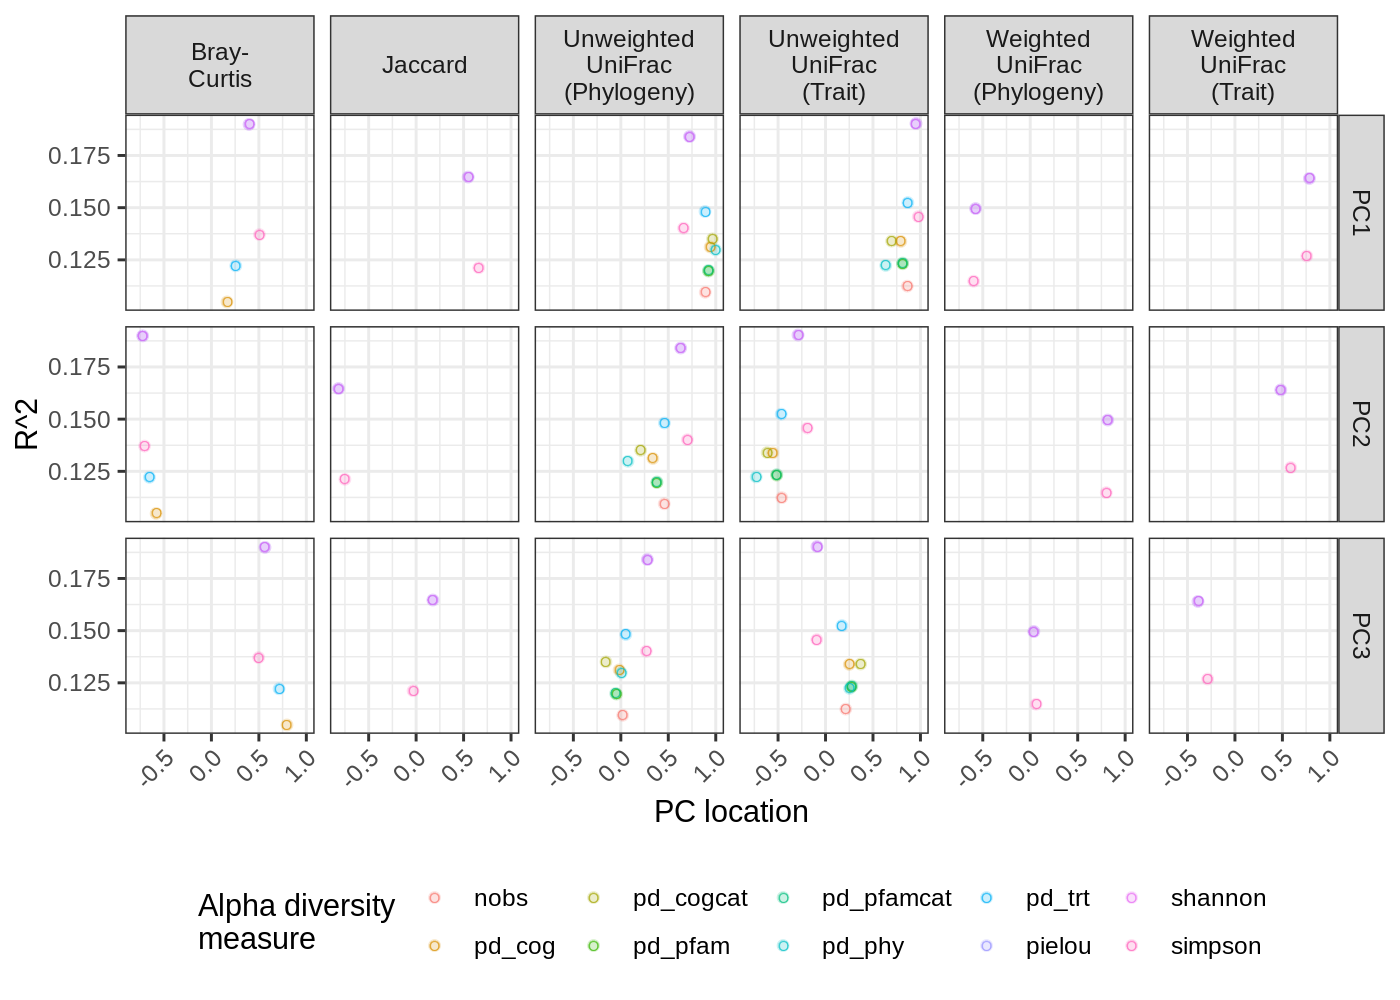

In [58]:
# plotting across PCs
p = specFit3 %>%
    filter.(r2 >= 0.1) %>%
    mutate.(Dim = gsub('Dim', 'PC', Dim)) %>%
    mutate.(distance = stringr::str_wrap(distance, 10)) %>%
    ggplot(aes(Dim_value, r2, color=name)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.7, shape='O') +
    scale_color_discrete('Alpha diversity\nmeasure') +
    labs(x='PC location', y='R^2') +
    facet_grid(Dim ~ distance) +
    theme_bw() +
    theme(
        legend.position='bottom',
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    guides(color=guide_legend(nrow=2))

p.dims(7,5)
plot(p)

## PCoA

In [50]:
F = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/beta-div_pcoa.tsv'
brk_cls_pcoa = read.delim(F, sep='\t') %>%
    filter(!grepl('cat', distance)) %>%
    mutate(distance_percExp12 = gsub('^bray', 'Bray-Curtis', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^jaccard', 'Jaccard', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^unifrac_cog', 'Uw. UniFrac (COG)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^unifrac_pfam', 'Uw. UniFrac (Pfam)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^unifrac_phy', 'Uw. UniFrac (Phylogeny)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^unifrac_trt', 'Uw. UniFrac (Trait)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^wunifrac_cog', 'W. UniFrac (COG)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^wunifrac_pfam', 'W. UniFrac (Pfam)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^wunifrac_phy', 'W. UniFrac (Phylogeny)', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub('^wunifrac_trt', 'W. UniFrac (Trait)', distance_percExp12)) 
brk_cls_pcoa

distance,PC1,PC2,PC3,PC4,PC5,PC1_perc_exp,PC2_perc_exp,PC3_perc_exp,PC4_perc_exp,PC5_perc_exp,sample,distance_percExp12,distance_percExp13,distance_percExp23
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
bray,-0.1804197,-0.01788646,-0.1861345,-0.1739163,0.11140233,15.57998,10.65934,4.797023,4.56758,2.988877,A01_02_1FE,"Bray-Curtis, PC1: 15.6%, PC2: 10.7%","bray, PC1: 15.6%, PC3: 4.8%","bray, PC2: 10.7%, PC3: 4.8%"
bray,-0.2904995,0.09745770,-0.2923586,-0.1891436,0.09415157,15.57998,10.65934,4.797023,4.56758,2.988877,A02_01_1FE,"Bray-Curtis, PC1: 15.6%, PC2: 10.7%","bray, PC1: 15.6%, PC3: 4.8%","bray, PC2: 10.7%, PC3: 4.8%"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
unifrac_pfam,0.1456141,-0.10690793,0.02227613,0.03618811,-0.001063667,13.57495,10.96272,6.332299,4.180537,2.386777,YSZC12003_37879,"Uw. UniFrac (Pfam), PC1: 13.6%, PC2: 11%","unifrac_pfam, PC1: 13.6%, PC3: 6.3%","unifrac_pfam, PC2: 11%, PC3: 6.3%"
unifrac_pfam,0.1776149,-0.05666312,0.03913063,0.07735136,-0.074201415,13.57495,10.96272,6.332299,4.180537,2.386777,YSZC12003_37880,"Uw. UniFrac (Pfam), PC1: 13.6%, PC2: 11%","unifrac_pfam, PC1: 13.6%, PC3: 6.3%","unifrac_pfam, PC2: 11%, PC3: 6.3%"


In [51]:
overlap(brk_cls_pcoa, alpha_div, sample, Sample)

brk_cls_pcoa = brk_cls_pcoa %>%
    inner_join(alpha_div, c('sample'='Sample'))
brk_cls_pcoa

intersect(x,y): 2943 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 2943 


distance,PC1,PC2,PC3,PC4,PC5,PC1_perc_exp,PC2_perc_exp,PC3_perc_exp,PC4_perc_exp,⋯,Metric_value,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized,disease_status
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>,<chr>
bray,-0.1804197,-0.01788646,-0.1861345,-0.1739163,0.1114023,15.57998,10.65934,4.797023,4.56758,⋯,232.000000,PasolliE_2018,A01_02_1FE,control,healthy,NA,,NA,FALSE,healthy
bray,-0.1804197,-0.01788646,-0.1861345,-0.1739163,0.1114023,15.57998,10.65934,4.797023,4.56758,⋯,3.888802,PasolliE_2018,A01_02_1FE,control,healthy,NA,,NA,FALSE,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
unifrac_pfam,0.1776149,-0.05666312,0.03913063,0.07735136,-0.07420142,13.57495,10.96272,6.332299,4.180537,⋯,38.17068,XieH_2016,YSZC12003_37880,control,,42,female,NA,TRUE,diseased
unifrac_pfam,0.1776149,-0.05666312,0.03913063,0.07735136,-0.07420142,13.57495,10.96272,6.332299,4.180537,⋯,23.25746,XieH_2016,YSZC12003_37880,control,,42,female,NA,TRUE,diseased


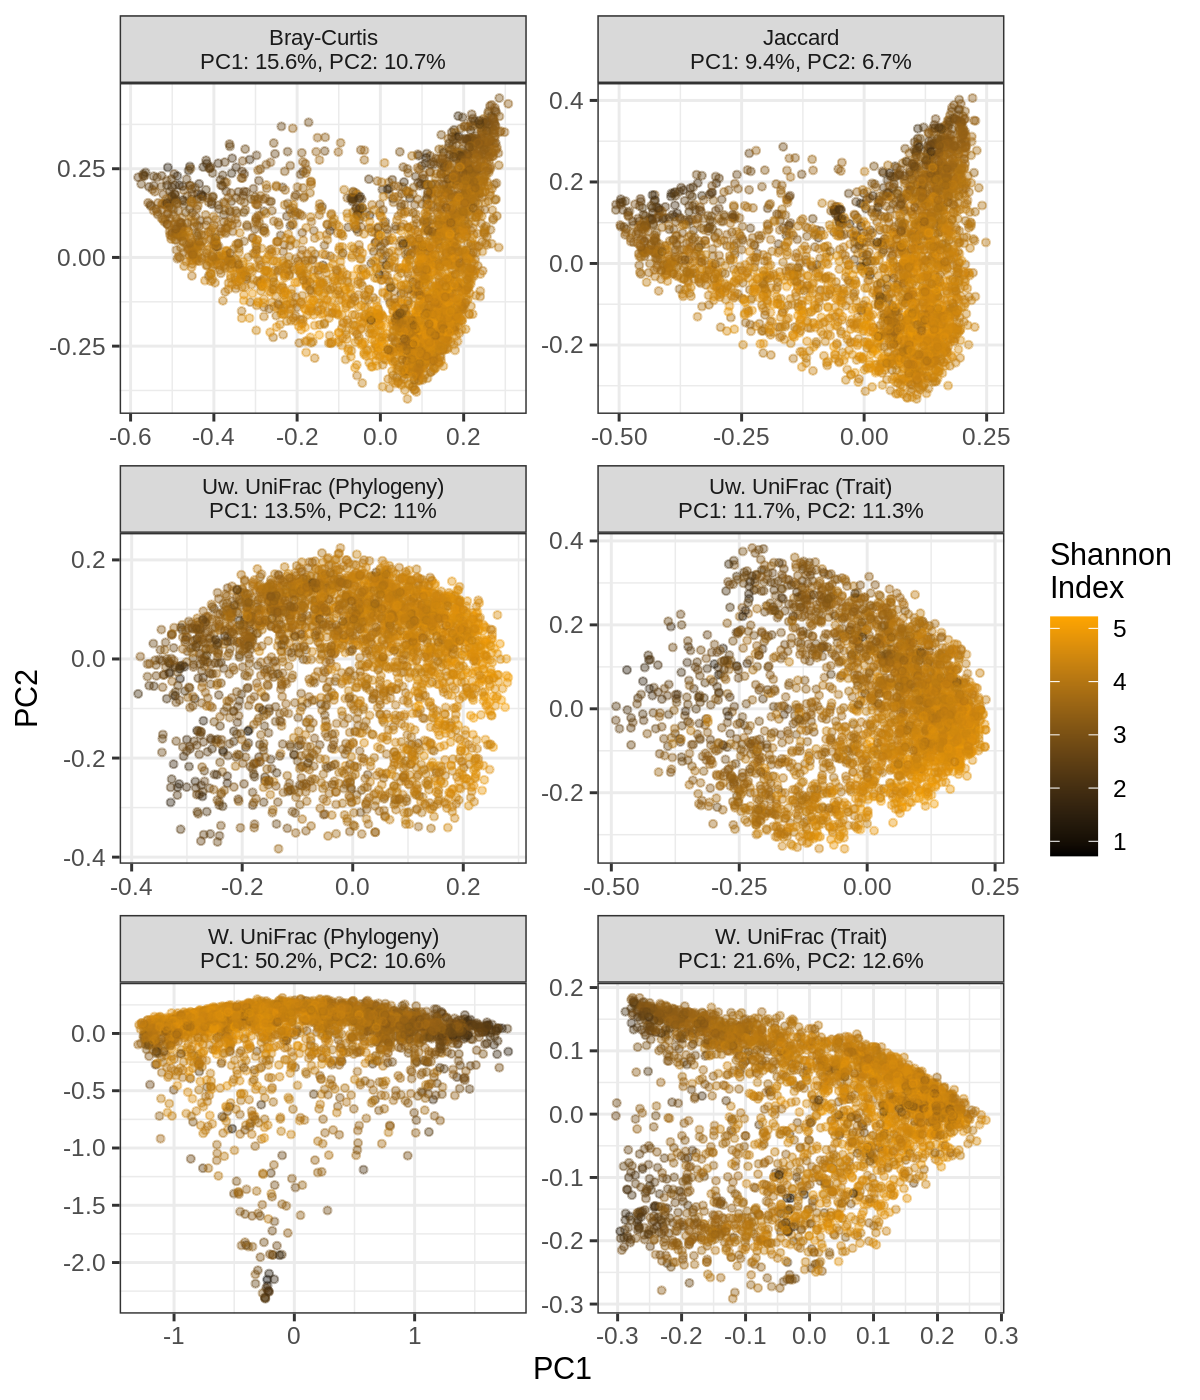

In [59]:
# alpha div
p = brk_cls_pcoa %>%
    filter(Metric == 'shannon',
           grepl('Bray|Jaccard|Trait|Phylogeny', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub(', PC1', '\nPC1', distance_percExp12)) %>%
    ggplot(aes(PC1, PC2, color=Metric_value)) +
    geom_point(size=1, alpha=0.4) +
    scale_color_gradient('Shannon\nIndex', low='black', high='orange') +
    facet_wrap(~ distance_percExp12, scales='free', ncol=2) +
    theme_bw() +
    theme(
        strip.text = element_text(size=8)
    )
p.dims(6,7)
plot(p)

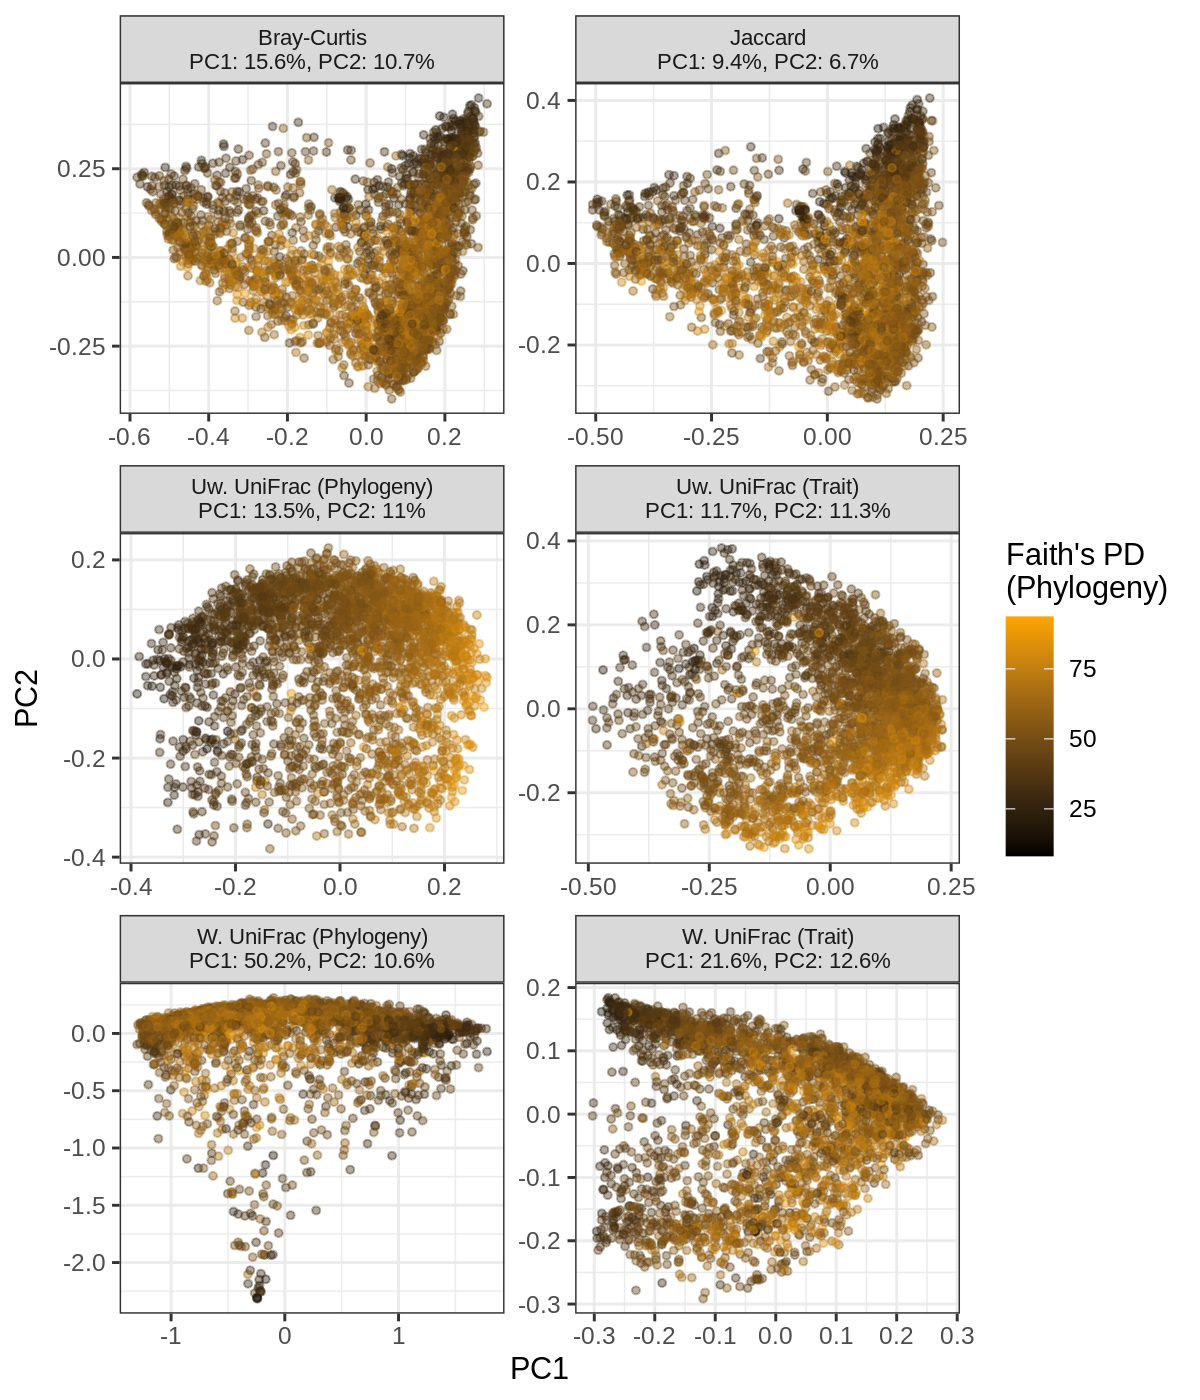

In [60]:
# alpha div
p = brk_cls_pcoa %>%
    filter(Metric == 'pd_phy',
           grepl('Bray|Jaccard|Trait|Phylogeny', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub(', PC1', '\nPC1', distance_percExp12)) %>%
    ggplot(aes(PC1, PC2, color=Metric_value)) +
    geom_point(size=1, alpha=0.4) +
    scale_color_gradient('Faith\'s PD\n(Phylogeny)', low='black', high='orange') +
    facet_wrap(~ distance_percExp12, scales='free', ncol=2) +
    theme_bw() +
    theme(
        strip.text = element_text(size=8)
    )
p.dims(6,7)
plot(p)

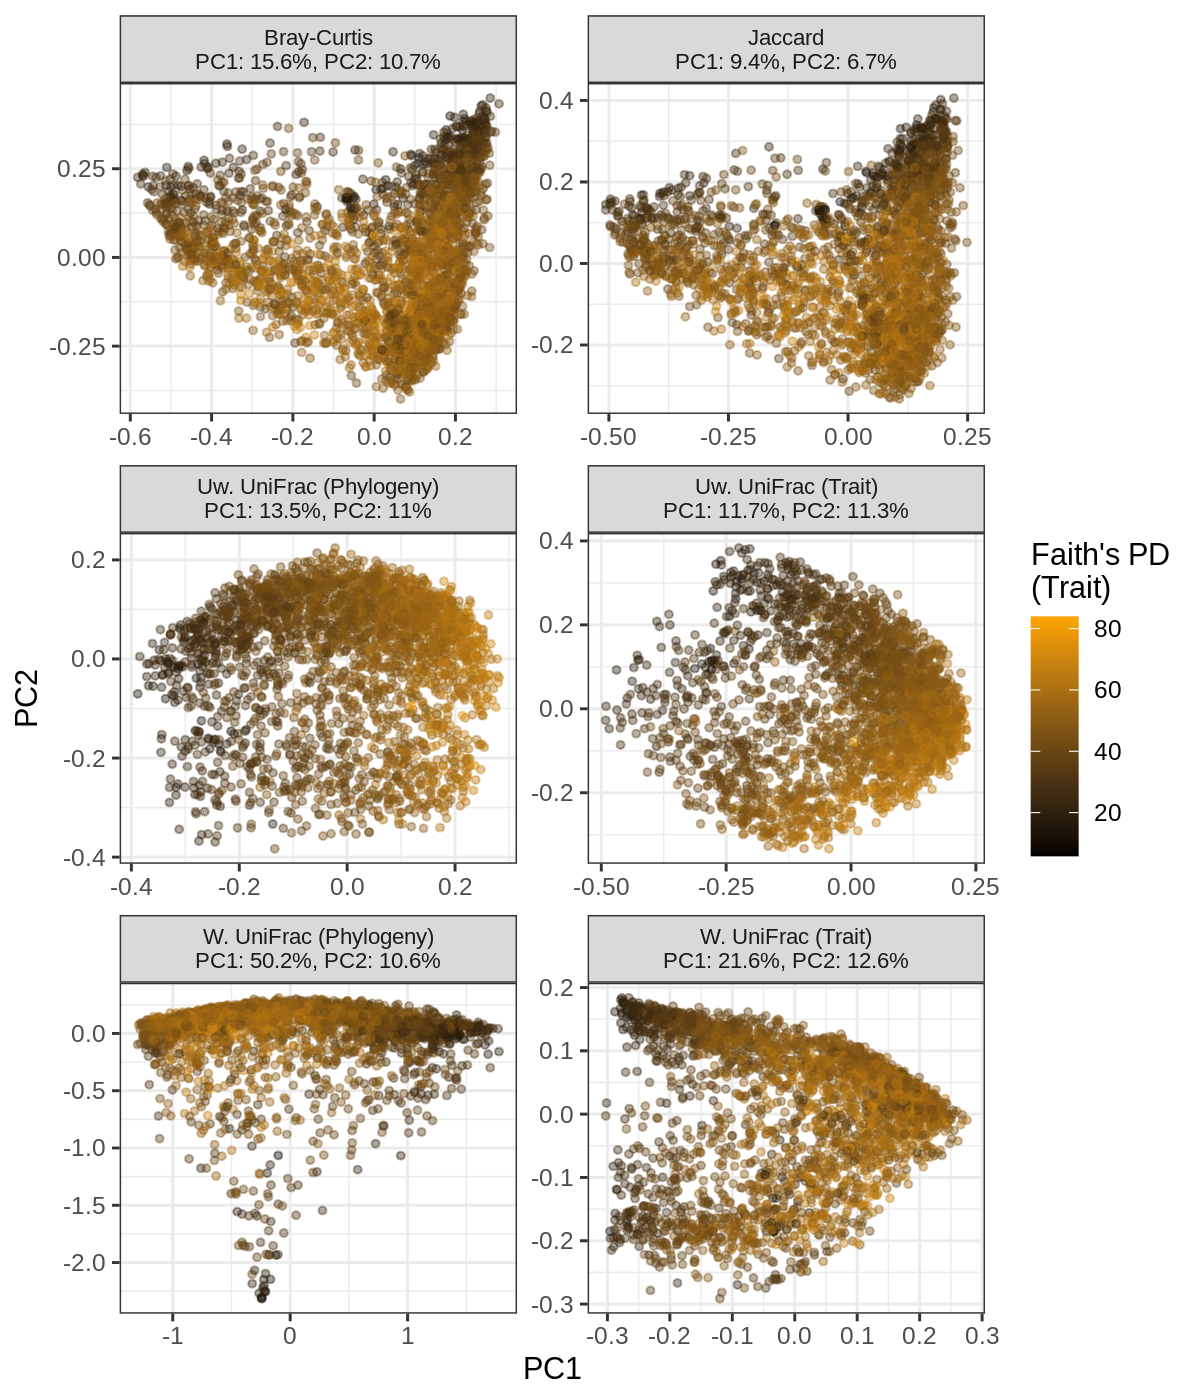

In [61]:
# alpha div
p = brk_cls_pcoa %>%
    filter(Metric == 'pd_trt',
           grepl('Bray|Jaccard|Trait|Phylogeny', distance_percExp12)) %>%
    mutate(distance_percExp12 = gsub(', PC1', '\nPC1', distance_percExp12)) %>%
    ggplot(aes(PC1, PC2, color=Metric_value)) +
    geom_point(size=1, alpha=0.4) +
    scale_color_gradient('Faith\'s PD\n(Trait)', low='black', high='orange') +
    facet_wrap(~ distance_percExp12, scales='free', ncol=2) +
    theme_bw() +
    theme(
        strip.text = element_text(size=8)
    )
p.dims(6,7)
plot(p)

# sessionInfo

In [55]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects2/global_metagenome_diversity/envs/phyloseq/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] LeyLabRMisc_0.2.0 vegan_2.5-7       lattice_0.20-45   permute_0.9-5    
 [5] phyloseq_1.36.0   ape_5.5           tidytable_0.6.5   data.table_1.14.0
 [9] ggplot2_3.3.5     tidyr_1.1.3       dplyr_1.0.7      

loaded via a namespace (and not attached):
 [1] Biobase_2.52.0 